# Exploration on NN pretrained using iRF

This notebook tries the idea of neural network to solve the enhancer data prediction problem. It explores several ways:

1. Vanilla 2 layer neural network.
2. Vanilla 2 layer NN + iRF pretraining.

In [119]:
import numpy as np
import sklearn 
from sklearn.preprocessing import scale
import torch as th
import pandas as pd
import scipy as sp
import scipy.optimize 
from sklearn.metrics import accuracy_score, mean_squared_error, f1_score, roc_auc_score, roc_curve
import sys
import copy
sys.path.append('../code/') 
from NN_learner import NN_learner
import matplotlib.pyplot as plt
from tensorboardX import SummaryWriter
from irf.ensemble import RandomForestClassifier
%matplotlib inline

### load data

In [2]:
X_train = np.array(pd.read_csv('../data/01_X_train.csv', header=0, index_col=0))
X_test = np.array(pd.read_csv('../data/02_X_test.csv', header=0, index_col=0))
y_train = np.array(pd.read_csv('../data/03_y_train.csv', header=0, index_col=0))
y_test = np.array(pd.read_csv('../data/04_y_test.csv', header=0, index_col=0))

<hr/>
## Method 1: directly train on the data
<hr/>

### training

In [17]:
sample_size = X_train.shape[0]
nn = NN_learner(X_train, y_train, 
                 initial_model = None,
                  max_iter=2e4, 
                  name='sample_.2_lr_1e-4_iter_2e4_ADAM',
                  batch_size=sample_size//5,
                  method = 'adam',
                  learning_rate = 1e-4)

### evaluating on the test set

In [53]:
y_pred = nn(th.tensor(X_test.astype(np.float32)).to('cuda')).cpu().data.numpy()

In [54]:
print('mean accuracy is %.4f'%(accuracy_score(y_test, y_pred > .5)))

mean accuracy is 0.9009


<hr/>
## Method 2: pretrained using RF
<hr/>

In [21]:
import pickle as pk
with open('../results/01_irf_model.pickle', 'rb') as f:
    rf = pk.load(f)

### test the accuracy of the RF

In [42]:
print(' IRF\'s mean accuracy is %.4f'%(accuracy_score(y_test, rf.predict(X_test))))

 IRF's mean accuracy is 0.9266


### get RF's prediction on the test set

In [70]:
X_new = X_test.copy()
y_new = rf.predict_proba(X_new)[:,1:2]

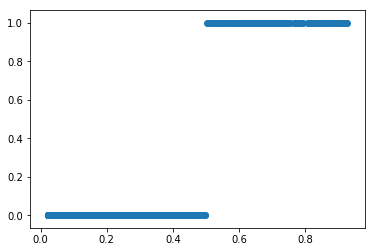

In [88]:
plt.scatter(y_new, rf.predict(X_new))

### Train the neural net

In [71]:
sample_size = X_new.shape[0]
nn_new = NN_learner(X_new, y_new, 
                    initial_model = None,
                    max_iter=1e5, 
                    name='pretrain_test_sample_.5_lr_1e-5_iter_1e5_ADAM',
                    batch_size=sample_size//2,
                    method = 'adam',
                    learning_rate = 1e-5)

### make sure the neural network has the same prediction accuracy

In [130]:
y_pred = nn_new(th.tensor(X_test.astype(np.float32)).to('cuda')).cpu().data.numpy()
print('mse between y_pred and RF is %.4f'%(mean_squared_error(rf.predict_proba(X_test)[:,1:2], y_pred)))
print('mean accuracy is %.4f'%(accuracy_score(y_test, y_pred > .4)))
print('f1 score is %.4f'%(f1_score(y_test, y_pred > .4)))
fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)
print('auc score is %.4f'%(auc(fpr, tpr)))
print('mse is %.4f'%(mean_squared_error(y_test, y_pred)))

mse between y_pred and RF is 0.0008
mean accuracy is 0.9230
f1 score is 0.4505
auc score is 0.8171
mse is 0.0595


### fine tuning on the training set

In [133]:
ratio = .001
whole_X_train = np.vstack([ratio * X_train, X_new])
whole_y_train = np.vstack([ratio * y_train, y_new])
sample_size = whole_X_train.shape[0]
nn_fine_tuning = NN_learner(whole_X_train, whole_y_train, 
                    initial_model = copy.deepcopy(nn_new),
                    max_iter=1e3,
                    name='fine_tune_joint_1_lr_1e-4_iter_1e3_ADAM',
                    batch_size=sample_size,
                    method = 'adam',
                    learning_rate = 1e-4)

In [134]:
y_pred = nn_fine_tuning(th.tensor(X_test.astype(np.float32)).to('cuda')).cpu().data.numpy()
print('mse between y_pred and RF is %.4f'%(mean_squared_error(rf.predict_proba(X_test)[:,1:2], y_pred)))
print('mean accuracy is %.4f'%(accuracy_score(y_test, y_pred > .4)))
print('f1 score is %.4f'%(f1_score(y_test, y_pred > .4)))
fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)
print('auc score is %.4f'%(auc(fpr, tpr)))
print('mse is %.4f'%(mean_squared_error(y_test, y_pred)))

mse between y_pred and RF is 0.0009
mean accuracy is 0.9222
f1 score is 0.4560
auc score is 0.8193
mse is 0.0597



### Observation:  __fine tuned NN is not as good as the original RF__